In [1]:
import sys
sys.path.append('..')

In [2]:
import planetengine
import modelscripts

In [3]:
from planetengine import quickShow

In [4]:
system = modelscripts.isovisc_systemscript.build(aspect = 7, res = 4)

In [5]:
import numpy as np
import math
import underworld as uw

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nProcs = comm.Get_size()

def boundary_interpolate(fromData, toData, dim):
    # NOT PARALLEL SAFE

    assert nProcs == 1

    fromField, fromMesh, fromIndexSet = fromData
    comp = 0
    outArrs = []
    while comp < dim:
        coordSet = fromMesh.data[fromIndexSet]
        previousCoord = coordSet[0]
        cumulativeDistance = 0.
        fromPositions = []
        fromValues = []
        for index, currentCoord in enumerate(coordSet):
            cumulativeDistance += math.hypot(
                currentCoord[0] - previousCoord[0],
                currentCoord[1] - previousCoord[1]
                )
            value = fromField.data[list(fromIndexSet)[index]][comp]
            fromPositions.append(cumulativeDistance)
            fromValues.append(value)
            previousCoord = currentCoord

        toField, toMesh, toIndexSet = toData
        coordSet = toMesh.data[toIndexSet]
        previousCoord = coordSet[0]
        cumulativeDistance = 0.
        toPositions = []
        for index, currentCoord in enumerate(coordSet):
            cumulativeDistance += math.hypot(
                currentCoord[0] - previousCoord[0],
                currentCoord[1] - previousCoord[1]
                )
            toPositions.append(cumulativeDistance)
            previousCoord = currentCoord

        toValues = np.interp(toPositions, fromPositions, fromValues)
        outArrs.append(toValues)
        comp += 1

    outArr = np.dstack(outArrs)

    toField.data[toIndexSet] = outArr

def get_scales(variable, partitioned = False):
    scales = []
    if type(variable) == np.ndarray:
        data = variable
    else:
        data = variable.data
    if partitioned:
        data = comm.gather(data, root = 0)
    if rank == 0:
        data = np.vstack(data)
        for i in range(data.shape[1]):
            scales.append(
                [data[:,i].min(),
                data[:,i].max()]
                )
    scales = comm.bcast(scales, root = 0)
    return scales

def recentered_coords(
        coordArray,
        origin = (0., 0.),
        inverse = False,
        ):

    if not inverse:
        outArray = coordArray - origin
    else:
        outArray = coordArray + origin

    return outArray

def radial_coords(
        coordArray,
        origin = (0., 0.),
        inverse = False,
        ):

    recenteredCoords = recentered_coords(coordArray, origin, inverse)

    if not inverse:
        xs, ys = recenteredCoords.transpose()
        angular = np.arctan2(ys, xs) * 180. / np.pi
        angular = np.where(angular >= 0., angular, angular + 360.)
        radial = np.hypot(xs, ys)
        outArray = np.dstack((angular, radial))[0]

    else:
        angular, radial = recenteredCoords.transpose()
        xs = radial * np.cos(angular * np.pi / 180.)
        ys = radial * np.sin(angular * np.pi / 180.)
        outArray = np.dstack((xs, ys))[0]

    return outArray

# def rotate_coords(
#         coordArray,
#         rotation
#         ):
#     # rotation is in degrees;
#     # positive is anticlockwise
#     angs, rads = coordArray.transpose()
#     angs += rotation
#     outArray = np.dstack((angs, rads))[0]
#     return outArray

def rescale_array(
        inArray,
        inScales,
        outScales,
        flip = None
        ):

    transposed = inArray.transpose()
    outVals = []
    for nD in range(len(transposed)):
        vals = transposed[nD]
        inScale = inScales[nD]
        outScale = outScales[nD]
        inRange = inScale[1] - inScale[0]
        outRange = outScale[1] - outScale[0]
        inMin, inMax = inScale
        outMin, outMax = outScale
        vals = ((vals - inMin) / inRange)
        if not flip == None:
            if flip[nD]:
                vals = 1. - vals
        vals = vals * outRange + outMin
        vals = np.clip(vals, outMin, outMax)
        outVals.append(vals)
    outArray = np.dstack(outVals)[0]
    return outArray

def box(mesh, coordArray = None, boxDims = ((0., 1), (0., 1.))):
    if coordArray is None:
        coordArray = mesh.data
    if type(mesh) == uw.mesh.FeMesh_Annulus:
        radialCoords = radial_coords(coordArray)
        inScales = [mesh.angularExtent, mesh.radialLengths]
#         rotatedCoords = rotate_coords(radialCoords, 
#         inScales = get_scales(radialCoords)
#         print(inScales)
        outScales = boxDims
        outArray = rescale_array(
            radialCoords,
            inScales,
            outScales,
            flip = [True, False]
            )
    else:
        outArray = rescale_array(
            coordArray,
            list(zip(mesh.minCoord, mesh.maxCoord)),
            boxDims
            )
    return outArray

def unbox(mesh, coordArray = None, boxDims = ((0., 1), (0., 1.))):
    if coordArray is None:
        coordArray = mesh.data
    outArray = radial_coords(
        rescale_array(
            coordArray,
            boxDims,
            (mesh.angularExtent, mesh.radialLengths),
            flip = [True, False]
            ),
        inverse = True
        )
    return outArray

Fitted 0 variables to the figure.



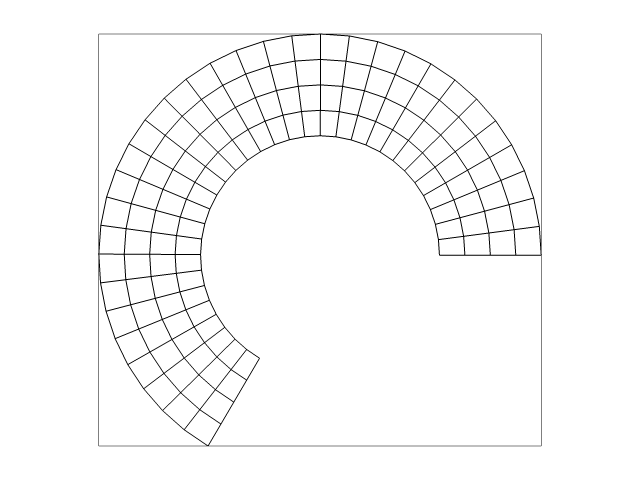

In [6]:
quickShow(system.mesh)

In [7]:
boxDims = ((0., 1.),) * system.mesh.dim
angBox = system.mesh.add_variable(1)
newAngBox = system.mesh.add_variable(1)
box = box(system.mesh, system.mesh.data, boxDims)
angBox.data[:] = box[:,0].reshape(angBox.data.shape)

Fitted 1 variables to the figure.



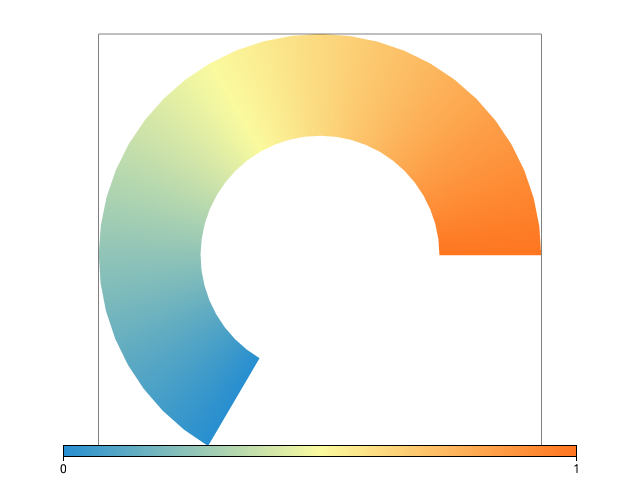

In [8]:
quickShow(angBox)

In [ ]:
def rotate_coords(
        coordArray,
        rotation
        ):
    # rotation is in degrees;
    # positive is anticlockwise
    angs, rads = coordArray.transpose()
    angs += rotation
    outArray = np.dstack((angs, rads))[0]
    return outArray

In [ ]:
angBox.data[:] = rotate_coords(box, 100.)[:,0].reshape(angBox.data.shape)

In [ ]:
import numpy as np

In [ ]:
xs, ys = system.mesh.data.transpose()
newAngBox.data[:] = np.vstack(np.arctan2(ys, xs) * 180. / np.pi)

In [ ]:
quickShow(newAngBox)

In [ ]:
newAngBox.data[:] = rescale_array(newAngBox.data, get_scales(newAngBox.data), [[0., 1]])

In [ ]:
quickShow(newAngBox)

In [ ]:
from planetengine.mapping import rescale_array
from planetengine.mapping import radial_coords
from planetengine.mapping import get_scales

coordArray = system.mesh.data

radialCoords = radial_coords(coordArray)
inScales = get_scales(radialCoords)
outScales = boxDims
outArray = rescale_array(
    radialCoords,
    inScales,
    outScales,
    flip = [True, False]
    )

newAngBox.data[:] = outArray[:,0].reshape(newAngBox.data.shape)

In [ ]:
quickShow(newAngBox)

In [ ]:
system.mesh.angularExtent

In [ ]:
system.mesh.radialLengths